## Part 0: Initialization
### Step zero: Import Libraries

In [1]:

import pandas as pd
import platform
import io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm


### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [2]:
# Define data transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainset_subset = torch.utils.data.Subset(trainset, range(2000))
# trainloader_minibatch = torch.utils.data.DataLoader(trainset_subset, batch_size=128, shuffle=True, num_workers=2)

# testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testset_subset = torch.utils.data.Subset(testset, range(2000))
# testloader_minibatch = torch.utils.data.DataLoader(testset_subset, batch_size=128, shuffle=False, num_workers=2)


In [5]:
# code here

# Load CIFAR-10 dataset
## GET download and then transform data to TENSOR & NORMALIZATION
''' number of samples that we want to load in each batch.
In this case, each batch will have 16 samples.

suffle randomise so not bias and randomize the order
'''
trainset= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader_minibatch = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Train Data shape:", trainset.data.shape)
print("Test Data shape:", testset.data.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Data shape: (50000, 32, 32, 3)
Test Data shape: (10000, 32, 32, 3)


In [6]:
print("training dataset size:", len(trainset))
print("test dataset size:", len(testset))

training dataset size: 50000
test dataset size: 10000


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Train Data shape:", trainset.data.shape)
print("Test Data shape:", testset.data.shape)

Train Data shape: (50000, 32, 32, 3)
Test Data shape: (10000, 32, 32, 3)


torch.Size([64, 3, 32, 32])
torch.Size([64])


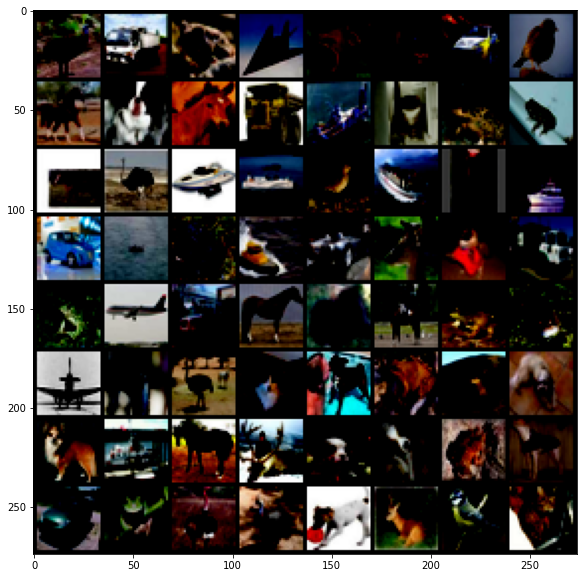

In [8]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_minibatch)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

#### mlp

# imp
conv2d(in_channels, out_channels, kernel_size, stride, padding, output_padding) :
 the in_channels parameter is the number of input channels (i.e. the number of feature maps in the previous layer), and the out_channels parameter is the number of output channels (i.e. the number of feature maps in the current layer).

output_size = ((input_size - kernel_size + 2*padding)/stride) + 1

In [9]:

import torch.nn as nn

class MLPAutoEncoder(nn.Module):

  def __init__(self):
      super(MLPAutoEncoder, self).__init__()

      # Encoder layers
      self.encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(3072, 512),
          nn.ReLU(),
          nn.Linear(512, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU()
      )

      # Decoder layers
      self.decoder = nn.Sequential(
          nn.Linear(32, 64),
          nn.ReLU(),
          nn.Linear(64, 512),
          nn.ReLU(),
          nn.Linear(512, 3072),
          nn.Sigmoid(),
          nn.Unflatten(1,(3,32,32))
      )

  def forward(self, x):
      # x = x.view(x.size()[0], -1)
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      
      return encoded, decoded



In [10]:
import torch
import torch.nn as nn

class ComboAutoEncoder(nn.Module):
    def __init__(self):
        super(ComboAutoEncoder, self).__init__()
        ''' 1 +  (n-k + 2p) / s  
        input = 3x32x32
        '''
        # Encoder layers
        self.encoder = nn.Sequential(
             # input: (batch_size, 3, 32, 32), 
             #outchanel = filters
             #kernel size of filter
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            #1 + (32-3+2)/1 = 32
            #  output: (batch_size, 16, 32, 32)
            # 16 filters
            nn.ReLU(),
            # input: (batch_size, 16, 32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 1 + (32-2+0)/2 = 16
            #  output: (batch_size, 16, 16, 16)


            # input: (batch_size, 16, 16, 16), 
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            # 1 + (16 - 3 +2) =16
            # output: (batch_size, 32, 16, 16)
            # '''
            #  Increasing the number of filters can help 
            #  the network to capture more complex patterns
            #  in the data, which can lead to better performance
            #  in tasks such as image classification or
            #  reconstruction.
            #  '''
            nn.ReLU(),
            # input: (batch_size, 32, 16, 16)
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 1 + (16-2+0)/2 = 8
            # output: (batch_size, 32, 8, 8)
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 32)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            # input: (batch_size, 32), 
            nn.Linear(32, 32 * 8 * 8),
            # output: (batch_size, 32 * 8 * 8)
            nn.ReLU(),
             # input: (batch_size, 32 * 8 * 8), 
            nn.Unflatten(-1, (32, 8, 8)),
             # input: (batch_size, 32, 8, 8), 
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            #  output: (batch_size, 16, 16, 16)
            nn.ReLU(),
             # input: (batch_size, 16, 16, 16), 
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1), 
            #  output: (batch_size, 3, 32, 32)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [11]:
import torch.nn as nn

class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            # Input size: (batch_size, 3, 32, 32)
            nn.Conv2d(3, 32, kernel_size=3, stride =1, padding=1),
            # Output: 32(filters) x (1 + (32 - 3 + 2)/1) = 32 x 32
            nn.ReLU(inplace=True),

             # input: (batch_size, 32, 32, 32), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            ##(n-k + 2p / s   + 1) = (32 - 2 + 0)/2 + 1 = 16
            # output: 32(filters) x size 16 x 16 

            nn.Conv2d(32, 16, kernel_size=3 , stride=1, padding=1),
            ## 32 input channel 16 output cahnnels 
            #output : (16 filters) x 16 x 16 due to padding
            nn.ReLU(inplace=True),
            #input : (16 filters) x 16 x 16 
            nn.MaxPool2d(kernel_size=2, stride=2),
             #output : 1 + (16 - 2)/2 = 8  
            # Input: (batch_size, 16, 8, 8)
            nn.Conv2d(16, 2, kernel_size=3 , stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)

            #output 
        )      

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
              # Output: (N, 16, 8, 8)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
              # Output: (N, 32, 16, 16)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  
            # Output: (N, 3, 32, 32)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [12]:
import matplotlib.pyplot as plt

def Mseloss_plot(TL , VL, optimizers):
  plt.figure(figsize=(10, 6))
  for opt_name, optimizer in optimizers.items():
      plt.plot(TL[opt_name], label=f"{opt_name} Train")
      plt.plot(VL[opt_name], label=f"{opt_name} Validation")

  plt.title('Loss per Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [13]:
def train(model):
  EPOCHS = 20
  loss_m = nn.MSELoss()
  device = ('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device) 

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  optimizers = {"optimizer_Adam" : optimizer}
  train_loss = {opt_name: [] for opt_name in optimizers}
  val_loss = {opt_name: [] for opt_name in optimizers}
  # Train the MLP with each optimizer and store the losses

  for opt_name, optimizer in optimizers.items():
    print(f"Training with optimizer: {opt_name}")

    #  # Move model to the same device as the data
    start_time = time.time()
    for epoch in range(EPOCHS):
      pbar = tqdm(total=len(trainloader_minibatch))
      out_loss = 0
      epoch_train_loss = 0.0
      epoch_test_loss = 0.0

      for batch_idx, (data, target) in enumerate(trainloader_minibatch):
        optimizer.zero_grad()
        '''ensures that we start with a clean slate
         for the gradients of the current batch, so
          that we can compute the gradients for that
          batch without interference from the
          gradients computed for previous batches.
        '''
        # Move data to GPU if available
        data, target = data.to(device), target.to(device)
        # Compute the forward pass
        decoded = model(data)[1]
        # Compute the loss
        loss = loss_m(decoded, data)
        # Compute gradients and update weights
        loss.backward()
        optimizer.step()
        # Accumulate the loss
        out_loss += loss.cpu().data.item()
        pbar.update(1)
        pbar.desc= f'Loss: {loss.item()}'

        # Accumulate the loss
        epoch_train_loss += loss.item() * data.size(0)
      # Store the training loss for the current epoch and optimizer
      train_loss[opt_name].append(out_loss/len(trainloader_minibatch))

      with torch.no_grad():
        out_loss = 0
        for batch_idx, (data, target) in enumerate(testloader_minibatch):
          # Move data to GPU if available
          data, target = data.to(device), target.to(device)
          # Compute forward pass
          decoded = model(data)[1]
          # Compute the loss
          loss =  loss_m(decoded, data)
          # Accumulate the loss
          out_loss += loss.cpu().data.item()
          epoch_test_loss += loss.item() * data.size(0)
        # Store the validation loss for the current epoch and optimizer  
        val_loss[opt_name].append(out_loss/len(testloader_minibatch))
      # Print the epoch statistics
      epoch_train_loss /= len(trainset)
      epoch_test_loss /= len(testset)
      print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")  
      print()
      pbar.refresh()
      pbar.close()
  return train_loss,val_loss,optimizers



In [14]:
import torch.autograd as autograd
def recons1(model):

  dataiter = iter(trainloader_minibatch)
  images, labels = next(dataiter)
  print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
  imshow(torchvision.utils.make_grid(images))

  images = autograd.Variable(images)

  print("Reconstructed image")
  decoded_imgs = model(images)[1]
  imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [15]:
import torch.autograd as autograd
def recons(model):

  dataiter = iter(trainloader_minibatch)
  images, labels = next(dataiter)
  print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
  imshow(torchvision.utils.make_grid(images))

  # images = autograd.Variable(images)
  images = images.to(next(model.parameters()).device)

  print("Reconstructed image")
  decoded_imgs = model(images)[1].cpu()
  imshow(torchvision.utils.make_grid(decoded_imgs.data))


In [16]:
import pandas as pd
import time
def frame(model,TL,VL,optimizers,start_time):
  EPOCHS = 20
  results = pd.DataFrame(columns=['Optimizer', 'Final Train Loss', 'Final Validation Loss', 'Model Size', 'Model Parameters', 'Time Taken per Epoch'])
  
  for opt_name, optimizer in optimizers.items():
      model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
      model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
      time_per_epoch = (time.time() - start_time) / EPOCHS
      results = results.append({'Optimizer': opt_name, 
                                'Final Train Loss': TL[opt_name][-1], 
                                'Final Validation Loss': VL[opt_name][-1], 
                                'Model Size': model_size, 
                                'Model Parameters': model_params,
                                'Time Taken per Epoch': time_per_epoch}, ignore_index=True)

  print(results)

# mlp

Training with optimizer: optimizer_Adam


Loss: 0.17597118020057678: 100%|██████████| 782/782 [00:21<00:00, 35.77it/s]


Epoch 1/20, Train Loss: 0.1970, Test Loss: 0.1776



Loss: 0.16595196723937988: 100%|██████████| 782/782 [00:18<00:00, 43.00it/s]


Epoch 2/20, Train Loss: 0.1764, Test Loss: 0.1712



Loss: 0.18691730499267578: 100%|██████████| 782/782 [00:17<00:00, 43.98it/s]


Epoch 3/20, Train Loss: 0.1724, Test Loss: 0.1690



Loss: 0.1682865023612976: 100%|██████████| 782/782 [00:17<00:00, 44.97it/s]


Epoch 4/20, Train Loss: 0.1705, Test Loss: 0.1676



Loss: 0.13038037717342377: 100%|██████████| 782/782 [00:18<00:00, 41.84it/s]


Epoch 5/20, Train Loss: 0.1693, Test Loss: 0.1664



Loss: 0.18793833255767822: 100%|██████████| 782/782 [00:17<00:00, 44.45it/s]


Epoch 6/20, Train Loss: 0.1682, Test Loss: 0.1653



Loss: 0.1579589694738388: 100%|██████████| 782/782 [00:18<00:00, 42.26it/s]


Epoch 7/20, Train Loss: 0.1672, Test Loss: 0.1648



Loss: 0.1529274433851242: 100%|██████████| 782/782 [00:17<00:00, 43.70it/s]


Epoch 8/20, Train Loss: 0.1666, Test Loss: 0.1644



Loss: 0.18068969249725342: 100%|██████████| 782/782 [00:17<00:00, 44.47it/s]


Epoch 9/20, Train Loss: 0.1662, Test Loss: 0.1640



Loss: 0.1713341772556305: 100%|██████████| 782/782 [00:18<00:00, 41.55it/s]


Epoch 10/20, Train Loss: 0.1657, Test Loss: 0.1637



Loss: 0.14995265007019043: 100%|██████████| 782/782 [00:17<00:00, 44.33it/s]


Epoch 11/20, Train Loss: 0.1654, Test Loss: 0.1634



Loss: 0.1313217729330063: 100%|██████████| 782/782 [00:19<00:00, 41.13it/s]


Epoch 12/20, Train Loss: 0.1652, Test Loss: 0.1632



Loss: 0.13269340991973877: 100%|██████████| 782/782 [00:17<00:00, 44.08it/s]


Epoch 13/20, Train Loss: 0.1649, Test Loss: 0.1629



Loss: 0.17237286269664764: 100%|██████████| 782/782 [00:18<00:00, 42.21it/s]


Epoch 14/20, Train Loss: 0.1647, Test Loss: 0.1627



Loss: 0.18513447046279907: 100%|██████████| 782/782 [00:18<00:00, 41.27it/s]


Epoch 15/20, Train Loss: 0.1645, Test Loss: 0.1629



Loss: 0.2082497775554657: 100%|██████████| 782/782 [00:27<00:00, 28.17it/s]


Epoch 16/20, Train Loss: 0.1644, Test Loss: 0.1630



Loss: 0.14674682915210724: 100%|██████████| 782/782 [00:18<00:00, 42.01it/s]


Epoch 17/20, Train Loss: 0.1643, Test Loss: 0.1628



Loss: 0.10233670473098755: 100%|██████████| 782/782 [00:19<00:00, 39.40it/s]


Epoch 18/20, Train Loss: 0.1641, Test Loss: 0.1625



Loss: 0.1616409868001938: 100%|██████████| 782/782 [00:19<00:00, 39.15it/s]


Epoch 19/20, Train Loss: 0.1640, Test Loss: 0.1630



Loss: 0.18426689505577087: 100%|██████████| 782/782 [00:18<00:00, 43.39it/s]

Epoch 20/20, Train Loss: 0.1640, Test Loss: 0.1627



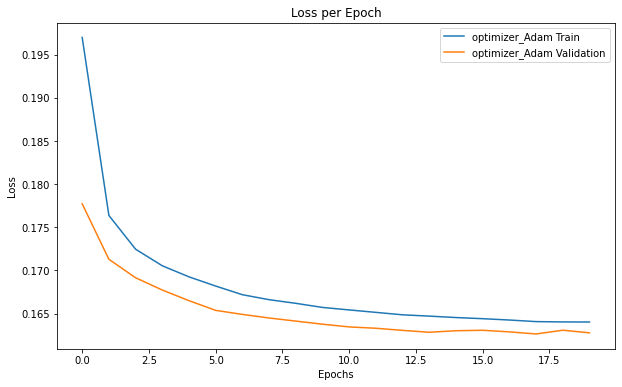

In [17]:
mlp = MLPAutoEncoder()
st1 = time.time()
train_loss1, val_loss1,optimizers = train(mlp)
Mseloss_plot(train_loss1,val_loss1,optimizers)

GroundTruth:  truck   cat horse   car  ship


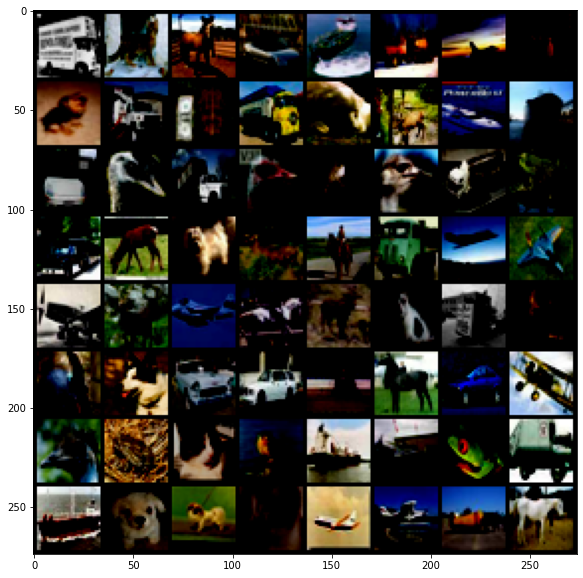

Reconstructed image


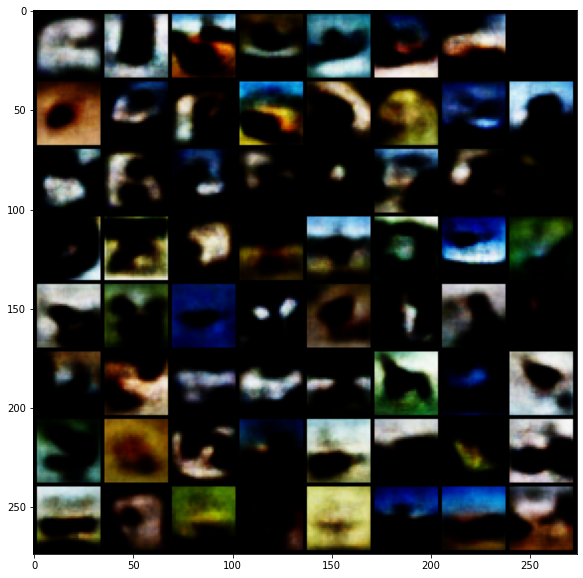

In [18]:
recons(mlp)
dev = ('cuda' if torch.cuda.is_available() else 'cpu')
print(dev)

In [19]:
frame(mlp, train_loss1, val_loss1,optimizers,st1)

        Optimizer  Final Train Loss  Final Validation Loss Model Size  \
0  optimizer_Adam          0.164022                0.16277    3219616   

  Model Parameters  Time Taken per Epoch  
0          3219616             19.293164  


<ipython-input-16-3ed0109f9457>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Optimizer': opt_name,


## ComboAutoEncoder

Training with optimizer: optimizer_Adam


Loss: 0.1901487112045288: 100%|██████████| 782/782 [00:23<00:00, 32.79it/s]


Epoch 1/20, Train Loss: 0.2083, Test Loss: 0.1748



Loss: 0.12816952168941498: 100%|██████████| 782/782 [00:19<00:00, 40.48it/s]


Epoch 2/20, Train Loss: 0.1725, Test Loss: 0.1644



Loss: 0.16163861751556396: 100%|██████████| 782/782 [00:19<00:00, 40.57it/s]


Epoch 3/20, Train Loss: 0.1653, Test Loss: 0.1614



Loss: 0.14383403956890106: 100%|██████████| 782/782 [00:20<00:00, 38.78it/s]


Epoch 4/20, Train Loss: 0.1635, Test Loss: 0.1604



Loss: 0.1486259251832962: 100%|██████████| 782/782 [00:18<00:00, 41.24it/s]


Epoch 5/20, Train Loss: 0.1628, Test Loss: 0.1598



Loss: 0.1408119797706604: 100%|██████████| 782/782 [00:20<00:00, 38.91it/s]


Epoch 6/20, Train Loss: 0.1624, Test Loss: 0.1595



Loss: 0.1491084098815918: 100%|██████████| 782/782 [00:19<00:00, 40.99it/s]


Epoch 7/20, Train Loss: 0.1621, Test Loss: 0.1593



Loss: 0.132808655500412: 100%|██████████| 782/782 [00:20<00:00, 37.96it/s]


Epoch 8/20, Train Loss: 0.1618, Test Loss: 0.1592



Loss: 0.21175937354564667: 100%|██████████| 782/782 [00:19<00:00, 40.81it/s]


Epoch 9/20, Train Loss: 0.1616, Test Loss: 0.1588



Loss: 0.1432759016752243: 100%|██████████| 782/782 [00:19<00:00, 39.32it/s]


Epoch 10/20, Train Loss: 0.1614, Test Loss: 0.1589



Loss: 0.1612662672996521: 100%|██████████| 782/782 [00:18<00:00, 41.56it/s]


Epoch 11/20, Train Loss: 0.1613, Test Loss: 0.1585



Loss: 0.2228374481201172: 100%|██████████| 782/782 [00:19<00:00, 39.66it/s]


Epoch 12/20, Train Loss: 0.1611, Test Loss: 0.1586



Loss: 0.16208086907863617: 100%|██████████| 782/782 [00:19<00:00, 40.44it/s]


Epoch 13/20, Train Loss: 0.1610, Test Loss: 0.1584



Loss: 0.17017672955989838: 100%|██████████| 782/782 [00:20<00:00, 38.90it/s]


Epoch 14/20, Train Loss: 0.1609, Test Loss: 0.1583



Loss: 0.18804535269737244: 100%|██████████| 782/782 [00:19<00:00, 40.54it/s]


Epoch 15/20, Train Loss: 0.1608, Test Loss: 0.1583



Loss: 0.20084035396575928: 100%|██████████| 782/782 [00:20<00:00, 38.83it/s]


Epoch 16/20, Train Loss: 0.1607, Test Loss: 0.1581



Loss: 0.13995704054832458: 100%|██████████| 782/782 [00:19<00:00, 40.61it/s]


Epoch 17/20, Train Loss: 0.1606, Test Loss: 0.1580



Loss: 0.1737326979637146: 100%|██████████| 782/782 [00:19<00:00, 39.53it/s]


Epoch 18/20, Train Loss: 0.1605, Test Loss: 0.1580



Loss: 0.17047643661499023: 100%|██████████| 782/782 [00:19<00:00, 40.94it/s]


Epoch 19/20, Train Loss: 0.1605, Test Loss: 0.1581



Loss: 0.1810750961303711: 100%|██████████| 782/782 [00:20<00:00, 38.89it/s]

Epoch 20/20, Train Loss: 0.1604, Test Loss: 0.1578



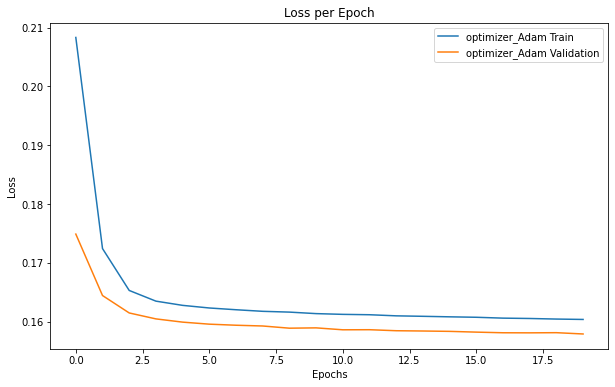

In [20]:
combo = ComboAutoEncoder()
st2 = time.time()
train_loss2, val_loss2,optimizers = train(combo)
Mseloss_plot(train_loss2,val_loss2,optimizers)

In [21]:
frame(combo, train_loss2, val_loss2,optimizers,st2)


        Optimizer  Final Train Loss  Final Validation Loss Model Size  \
0  optimizer_Adam          0.160396               0.157928     143299   

  Model Parameters  Time Taken per Epoch  
0           143299             19.823577  


<ipython-input-16-3ed0109f9457>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Optimizer': opt_name,


GroundTruth:   ship  frog   dog  bird   dog


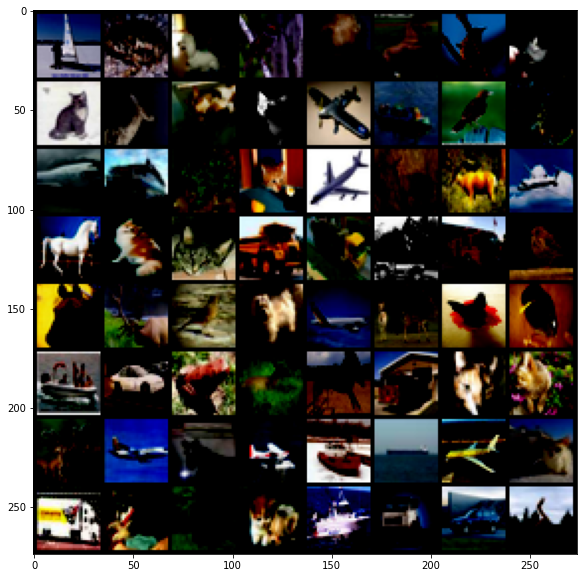

Reconstructed image


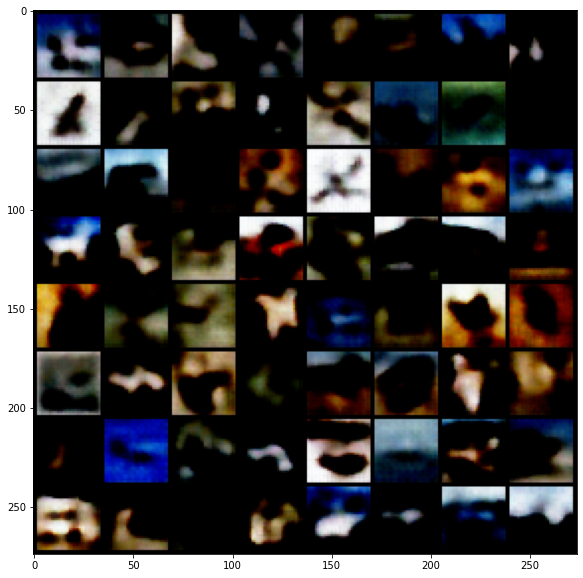

In [22]:
recons(combo)


##reconstruct

##cnn only



Training with optimizer: optimizer_Adam


Loss: 0.195962592959404: 100%|██████████| 782/782 [00:19<00:00, 39.25it/s]


Epoch 1/20, Train Loss: 0.2158, Test Loss: 0.1825



Loss: 0.1730850785970688: 100%|██████████| 782/782 [00:18<00:00, 41.82it/s]


Epoch 2/20, Train Loss: 0.1803, Test Loss: 0.1759



Loss: 0.19136129319667816: 100%|██████████| 782/782 [00:19<00:00, 39.17it/s]


Epoch 3/20, Train Loss: 0.1768, Test Loss: 0.1734



Loss: 0.15822899341583252: 100%|██████████| 782/782 [00:18<00:00, 41.79it/s]


Epoch 4/20, Train Loss: 0.1753, Test Loss: 0.1732



Loss: 0.17352795600891113: 100%|██████████| 782/782 [00:19<00:00, 39.37it/s]


Epoch 5/20, Train Loss: 0.1746, Test Loss: 0.1716



Loss: 0.17389944195747375: 100%|██████████| 782/782 [00:18<00:00, 41.71it/s]


Epoch 6/20, Train Loss: 0.1741, Test Loss: 0.1713



Loss: 0.1419098824262619: 100%|██████████| 782/782 [00:19<00:00, 39.37it/s]


Epoch 7/20, Train Loss: 0.1737, Test Loss: 0.1707



Loss: 0.2002212256193161: 100%|██████████| 782/782 [00:18<00:00, 41.73it/s]


Epoch 8/20, Train Loss: 0.1734, Test Loss: 0.1704



Loss: 0.16067224740982056: 100%|██████████| 782/782 [00:20<00:00, 38.96it/s]


Epoch 9/20, Train Loss: 0.1731, Test Loss: 0.1704



Loss: 0.16882960498332977: 100%|██████████| 782/782 [00:18<00:00, 41.69it/s]


Epoch 10/20, Train Loss: 0.1728, Test Loss: 0.1699



Loss: 0.20320335030555725: 100%|██████████| 782/782 [00:20<00:00, 38.96it/s]


Epoch 11/20, Train Loss: 0.1726, Test Loss: 0.1697



Loss: 0.17841248214244843: 100%|██████████| 782/782 [00:18<00:00, 41.69it/s]


Epoch 12/20, Train Loss: 0.1724, Test Loss: 0.1696



Loss: 0.18125592172145844: 100%|██████████| 782/782 [00:19<00:00, 39.25it/s]


Epoch 13/20, Train Loss: 0.1722, Test Loss: 0.1697



Loss: 0.1788673996925354: 100%|██████████| 782/782 [00:19<00:00, 41.04it/s]


Epoch 14/20, Train Loss: 0.1721, Test Loss: 0.1696



Loss: 0.16439437866210938: 100%|██████████| 782/782 [00:20<00:00, 38.45it/s]


Epoch 15/20, Train Loss: 0.1719, Test Loss: 0.1691



Loss: 0.16559737920761108: 100%|██████████| 782/782 [00:18<00:00, 41.82it/s]


Epoch 16/20, Train Loss: 0.1718, Test Loss: 0.1691



Loss: 0.15003858506679535: 100%|██████████| 782/782 [00:20<00:00, 38.95it/s]


Epoch 17/20, Train Loss: 0.1716, Test Loss: 0.1688



Loss: 0.15148219466209412: 100%|██████████| 782/782 [00:19<00:00, 41.11it/s]


Epoch 18/20, Train Loss: 0.1716, Test Loss: 0.1688



Loss: 0.21427077054977417: 100%|██████████| 782/782 [00:19<00:00, 39.20it/s]


Epoch 19/20, Train Loss: 0.1715, Test Loss: 0.1687



Loss: 0.15852907299995422: 100%|██████████| 782/782 [00:19<00:00, 41.12it/s]

Epoch 20/20, Train Loss: 0.1713, Test Loss: 0.1686



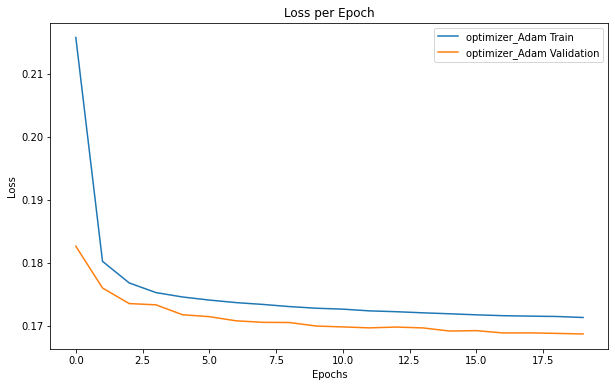

In [23]:
cnn = CNNAutoEncoder()
st3 = time.time()
train_loss3, val_loss3,optimizers = train(cnn)
Mseloss_plot(train_loss3,val_loss3,optimizers)

In [24]:
frame(cnn, train_loss3, val_loss3,optimizers,st3)


        Optimizer  Final Train Loss  Final Validation Loss Model Size  \
0  optimizer_Adam           0.17133               0.168713      11621   

  Model Parameters  Time Taken per Epoch  
0            11621             19.440508  


<ipython-input-16-3ed0109f9457>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Optimizer': opt_name,


GroundTruth:   ship truck  deer  frog   dog


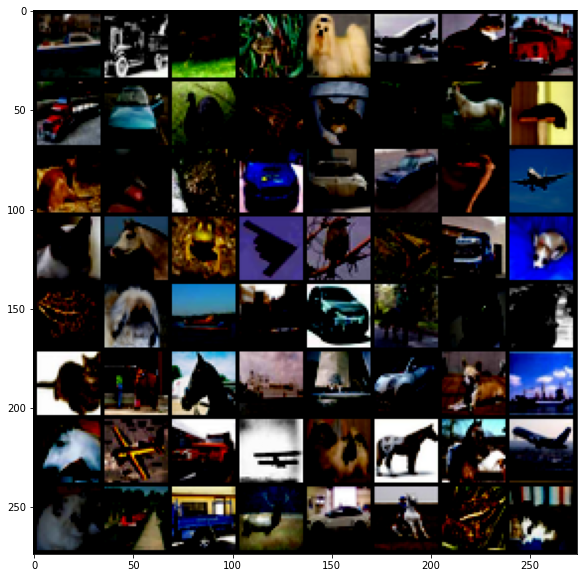

Reconstructed image


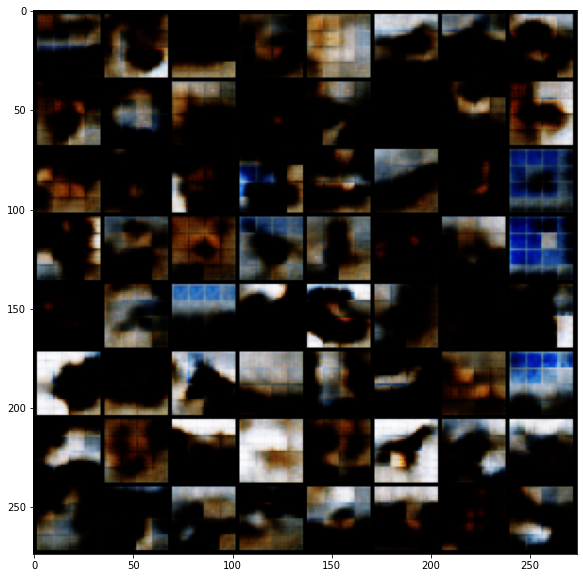

In [25]:
recons(cnn)

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

10

In [26]:
import torch.nn as nn

class CNNAutoEncoder10(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder10, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            # 32
            nn.Conv2d(3, 6, kernel_size=4, stride =2, padding=0),
            #32
            nn.ReLU(inplace=True),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            #16
            nn.Conv2d(6, 8, kernel_size=4 , stride=2, padding=0),
            nn.ReLU(inplace=True),
            # 16
            # nn.MaxPool2d(kernel_size=4, stride=4),
            #4
            nn.Conv2d(8, 10, kernel_size=4 , stride=2, padding=0),
            #4
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
            #1
            #output 
        )      

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(10, 8, kernel_size=4, stride=2, padding=0), 
              # Output: (N, 1, 8, 8)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 6, kernel_size=4, stride=2, padding=0), 
              # Output: (N, 32, 16, 16)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 3, kernel_size=6, stride=2, padding=0),  
            # Output: (N, 3, 32, 32)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        print("--------------------------------",encoded.shape)
        decoded = self.decoder(encoded)
        print("============================",decoded.shape)
        return encoded, decoded



In [27]:
cnn10 = CNNAutoEncoder10()
st3 = time.time()
train_loss3, val_loss3,optimizers = train(cnn10)
Mseloss_plot(train_loss3,val_loss3,optimizers)
recons(cnn10)

Output hidden; open in https://colab.research.google.com to view.

#100

In [28]:
# code and analysis here
import torch.nn as nn

class CNNAutoEncoder100(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder100, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            # 32
            nn.Conv2d(3, 6, kernel_size=2, stride =2, padding=0),
            #16
            nn.ReLU(inplace=True),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            #16
            nn.Conv2d(6, 8, kernel_size=2 , stride=2, padding=0),
            nn.ReLU(inplace=True),
            #8
            nn.Conv2d(8, 4, kernel_size=4 , stride=1, padding=0),
            #5
            nn.ReLU(inplace=True),

            # nn.MaxPool2d(kernel_size=2, stride=2)
            #1
            #output 
        )      

        self.decoder = nn.Sequential(
            # nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(4, 8, kernel_size=4, stride=1, padding=0), 
              # Output: (N, 1, 8, 8)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 6, kernel_size=2, stride=2, padding=0), 
              # Output: (N, 32, 16, 16)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 3, kernel_size=2, stride=2, padding=0),  
            # Output: (N, 3, 32, 32)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        print("--------------------------------",encoded.shape)
        decoded = self.decoder(encoded)
        print("============================",decoded.shape)
        return encoded, decoded




In [29]:
cnn100 = CNNAutoEncoder100()
st3 = time.time()
train_loss3, val_loss3,optimizers = train(cnn100)
Mseloss_plot(train_loss3,val_loss3,optimizers)
recons(cnn100)

Output hidden; open in https://colab.research.google.com to view.

#1000

In [30]:
# code and analysis here
import torch.nn as nn

class CNNAutoEncoder1000(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder1000, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            # 32
            nn.Conv2d(3, 6, kernel_size=4, stride =1, padding=0),
            #28
            nn.ReLU(inplace=True),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            #28
            nn.Conv2d(6, 8, kernel_size=2 , stride=2, padding=0),
            nn.ReLU(inplace=True),
            # 13
            # nn.MaxPool2d(kernel_size=4, stride=4),
            #13
            nn.Conv2d(8, 10, kernel_size=5 , stride=1, padding=0),
            #4
            nn.ReLU(inplace=True),

            # nn.MaxPool2d(kernel_size=2, stride=2)
            #1
            #output 
        )      

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(10, 8, kernel_size=5, stride=1, padding=0), 
              # Output: (N, 1, 8, 8)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 6, kernel_size=2, stride=2, padding=0), 
              # Output: (N, 32, 16, 16)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 3, kernel_size=5, stride=1, padding=0),  
            # Output: (N, 3, 32, 32)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        print("--------------------------------",encoded.shape)
        decoded = self.decoder(encoded)
        print("============================",decoded.shape)
        return encoded, decoded




In [31]:
cnn1000 = CNNAutoEncoder1000()
st3 = time.time()
train_loss3, val_loss3,optimizers = train(cnn1000)
Mseloss_plot(train_loss3,val_loss3,optimizers)
recons(cnn1000)

Output hidden; open in https://colab.research.google.com to view.

### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

#l1

In [32]:
import torch.nn as nn

class CNNAutoEncoder1L(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder1L, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            # 32
            nn.Conv2d(3, 6, kernel_size=5, stride =3, padding=0),
            #32
            nn.ReLU(inplace=True),

            #output 
        )      

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(6, 3, kernel_size=5, stride=3, padding=0),  
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        print("--------------------------------",encoded.shape)
        decoded = self.decoder(encoded)
        print("============================",decoded.shape)
        return encoded, decoded



In [33]:
cnn1L= CNNAutoEncoder1L()
st3 = time.time()
train_loss3, val_loss3,optimizers = train(cnn1L)
Mseloss_plot(train_loss3,val_loss3,optimizers)
recons(cnn1L)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# load an example dataset
from vega_datasets import data
cars = data.cars()

import altair as alt

interval = alt.selection_interval()

points = alt.Chart(cars).mark_point().encode(
  x='Horsepower',
  y='Miles_per_Gallon',
  color=alt.condition(interval, 'Origin', alt.value('lightgray'))
).properties(
  selection=interval
)

histogram = alt.Chart(cars).mark_bar().encode(
  x='count()',
  y='Origin',
  color='Origin'
).transform_filter(interval)

points & histogram

#3l


In [34]:
# code and analysis here
# code and analysis here
import torch.nn as nn

class CNNAutoEncoder3L(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder3L, self).__init__()

          # Encoder layers
        self.encoder = nn.Sequential(
              # Write your code here

              # fully convolutional layers.
              nn.Conv2d(3, 6, 4, stride=2, padding=1),
              nn.ReLU(),
              nn.Conv2d(6, 12, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
              nn.ReLU(),
              nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
              nn.ReLU()
          )
        self.decoder = nn.Sequential(
              # Write your code here
              #fully conv layers
              nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
              nn.ReLU(),
              nn.ConvTranspose2d(12, 6, 4, stride=2, padding=1),
              nn.ReLU(),
              nn.ConvTranspose2d(6, 3, 4, stride=2, padding=1),
              nn.ReLU()
            )
        
    def forward(self, x):
        encoded = self.encoder(x)
        print("--------------------------------",encoded.shape)
        decoded = self.decoder(encoded)
        print("============================",decoded.shape)
        return encoded, decoded





In [35]:
cnn3L = CNNAutoEncoder3L()
st3 = time.time()
train_loss3, val_loss3,optimizers = train(cnn3L)
Mseloss_plot(train_loss3,val_loss3,optimizers)
recons(cnn3L)

Output hidden; open in https://colab.research.google.com to view.

#5L

In [36]:
# code and analysis here
# code and analysis here
import torch.nn as nn

class CNNAutoEncoder5L(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder5L, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            
            nn.Conv2d(3, 6, kernel_size=3, stride =1, padding=0),
           
            nn.ReLU(inplace=True),

           
            nn.Conv2d(6, 8, kernel_size=3 , stride=1, padding=0),
            nn.ReLU(inplace=True),
           
            nn.Conv2d(8, 12, kernel_size=3 , stride=1, padding=0),
            #4
            nn.ReLU(inplace=True),

            nn.Conv2d(12, 16, kernel_size=4 , stride=1, padding=0),
            #4
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 20, kernel_size=3, stride=1, padding=0),
            #4
            nn.ReLU(inplace=True),

        )      

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(20, 16, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 12, kernel_size=4, stride=1, padding=0), 
              # Output: (N, 32, 16, 16)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(12, 8, kernel_size=3, stride=1, padding=0),  
            # Output: (N, 3, 32, 32)
            nn.ConvTranspose2d(8, 6, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 3, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(inplace=True),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        print("--------------------------------",encoded.shape)
        decoded = self.decoder(encoded)
        print("============================",decoded.shape)
        return encoded, decoded





In [37]:
cnn5L = CNNAutoEncoder5L()
st3 = time.time()
train_loss3, val_loss3,optimizers = train(cnn5L)
Mseloss_plot(train_loss3,val_loss3,optimizers)
recons(cnn5L)

Output hidden; open in https://colab.research.google.com to view.

#10L

In [38]:
# code and analysis here
# code and analysis here
import torch.nn as nn

class CNNAutoEncoder10L(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder10L, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            # 1
            nn.Conv2d(3, 6, kernel_size=2, stride =1, padding=0),
           
            nn.ReLU(inplace=True),

           #2
            nn.Conv2d(6, 8, kernel_size=2 , stride=1, padding=0),
            nn.ReLU(inplace=True),
           
            #3
            nn.Conv2d(8, 12, kernel_size=2 , stride=1, padding=0),
            nn.ReLU(inplace=True),

            #4
            nn.Conv2d(12, 15, kernel_size=2 , stride=1, padding=0),
            nn.ReLU(inplace=True),

            #5
            nn.Conv2d(15, 18, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),

            #6
            nn.Conv2d(18, 20, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),

            #7
            nn.Conv2d(20, 22, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),

            #8
            nn.Conv2d(22, 24, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),

            #9
            nn.Conv2d(24, 27, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            #10
           nn.Conv2d(27, 30, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )      

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(30, 27, kernel_size=3, stride=1, padding=0), 

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(27, 24, kernel_size=3, stride=1, padding=0), 

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(24, 22, kernel_size=2, stride=1, padding=0),  

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(22, 20, kernel_size=2, stride=1, padding=0),  

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(20, 18, kernel_size=2, stride=1, padding=0),  

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(18, 15, kernel_size=2, stride=1, padding=0),  

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(15, 12, kernel_size=2, stride=1, padding=0),  

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(12, 8, kernel_size=2, stride=1, padding=0),  

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 6, kernel_size=2, stride=1, padding=0),  

            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 3, kernel_size=2, stride=1, padding=0),  

            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        print("--------------------------------",encoded.shape)
        decoded = self.decoder(encoded)
        print("============================",decoded.shape)
        return encoded, decoded





In [39]:
cnn10L = CNNAutoEncoder10L()
st3 = time.time()
train_loss3, val_loss3,optimizers = train(cnn10L)
Mseloss_plot(train_loss3,val_loss3,optimizers)
recons(cnn10L)

Output hidden; open in https://colab.research.google.com to view.

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

In [40]:
# explainations here

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [41]:
# code and analysis here. Remember to keep your analysis of high quality at all times.